# Is this fire a false alarm? Real-time prediction of fire incident categories in spatio-temporal context

In [1]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import roc_auc_score
from pyproj import Transformer
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.patches as mpatches
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2

2024-07-17 18:54:15.854318: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-17 18:54:15.868797: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-17 18:54:15.882494: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-17 18:54:15.886837: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-17 18:54:15.900195: I tensorflow/core/platform/cpu_feature_guar

## Data Preprocessing

In [3]:
# Load the dataset
file_path = 'WMFS_datasets/wmfs_incidents.xlsx'
incidents_df = pd.read_excel(file_path)

In [4]:
# Display the first few rows to understand the structure of the dataset
print(incidents_df.head())
print(incidents_df.info())

            call_time             incident_classification_label  \
0 2009-01-01 00:00:39       False alarm raised with good intent   
1 2009-01-01 00:10:45                            Secondary fire   
2 2009-01-01 00:11:59  False alarm raised with malicious intent   
3 2009-01-01 00:53:02                            Secondary fire   
4 2009-01-01 00:52:13  False alarm raised with malicious intent   

                              incident_profile_label  \
0                                       False Alarms   
1  Secondary Fires that attract a 20 minute-respo...   
2                                       False Alarms   
3  Secondary Fires that attract a 20 minute-respo...   
4                                       False Alarms   

  incident_classification_level1  prl_count  brv_count       EASTINGS  \
0                    FALSE_ALARM          2          0  392062.102010   
1                           FIRE          1          0  405643.149442   
2                    FALSE_ALARM         

In [5]:
# Extract relevant columns
relevant_columns = [
    'call_time', 
    'incident_classification_level1', 
    'EASTINGS', 
    'NORTHINGS'
]

# Create a new DataFrame with only the relevant columns
incidents_df = incidents_df[relevant_columns]

# Display the first few rows of the extracted DataFrame
print(incidents_df.head())

            call_time incident_classification_level1       EASTINGS  \
0 2009-01-01 00:00:39                    FALSE_ALARM  392062.102010   
1 2009-01-01 00:10:45                           FIRE  405643.149442   
2 2009-01-01 00:11:59                    FALSE_ALARM  410260.244387   
3 2009-01-01 00:53:02                           FIRE  396779.250331   
4 2009-01-01 00:52:13                    FALSE_ALARM  410667.961350   

       NORTHINGS  
0  286844.969007  
1  277939.980158  
2  288819.189377  
3  299030.106069  
4  290492.478579  


In [6]:
# Filter to keep only FIRE and FALSE_ALARM incidents
incidents_df = incidents_df[incidents_df['incident_classification_level1'].isin(['FIRE', 'FALSE_ALARM'])]

# Filter the DataFrame to only include rows where the year is 2023
incidents_df = incidents_df[incidents_df['call_time'].dt.year == 2023]

# Display the filtered DataFrame
print(incidents_df.head())

                 call_time incident_classification_level1       EASTINGS  \
355773 2023-01-01 00:07:31                           FIRE  390939.345292   
355774 2023-01-01 00:10:35                           FIRE  434909.864296   
355775 2023-01-01 00:15:51                           FIRE  406439.483461   
355776 2023-01-01 00:22:20                           FIRE  435218.924925   
355777 2023-01-01 00:24:54                           FIRE  393699.370009   

            NORTHINGS  
355773  288314.930061  
355774  281352.454718  
355775  292133.553656  
355776  279144.353190  
355777  298870.429296  


## Feature Engineering

In [7]:
# Define peak and off-peak hours
def classify_peak_hours(hour):
    if (7 <= hour < 9) or (16 <= hour < 18):
        return 'Peak'
    else:
        return 'Off-Peak'

# Apply peak/off-peak classification
incidents_df['peak_hour'] = incidents_df['call_time'].dt.hour.apply(classify_peak_hours)

# Define weekdays and weekends
def classify_day_of_week(day):
    if day < 5:  # 0-4 are Monday to Friday
        return 'Weekday'
    else:
        return 'Weekend'

# Apply weekday/weekend classification
incidents_df['day_type'] = incidents_df['call_time'].dt.dayofweek.apply(classify_day_of_week)

# Define seasons
def classify_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

# Apply season classification
incidents_df['season'] = incidents_df['call_time'].dt.month.apply(classify_season)

# Display the DataFrame with new temporal features
print(incidents_df.head())

                 call_time incident_classification_level1       EASTINGS  \
355773 2023-01-01 00:07:31                           FIRE  390939.345292   
355774 2023-01-01 00:10:35                           FIRE  434909.864296   
355775 2023-01-01 00:15:51                           FIRE  406439.483461   
355776 2023-01-01 00:22:20                           FIRE  435218.924925   
355777 2023-01-01 00:24:54                           FIRE  393699.370009   

            NORTHINGS peak_hour day_type  season  
355773  288314.930061  Off-Peak  Weekend  Winter  
355774  281352.454718  Off-Peak  Weekend  Winter  
355775  292133.553656  Off-Peak  Weekend  Winter  
355776  279144.353190  Off-Peak  Weekend  Winter  
355777  298870.429296  Off-Peak  Weekend  Winter  


In [8]:
# Check unique values for each new temporal feature
print("Unique values for 'peak_hour':", incidents_df['peak_hour'].unique())
print("Unique values for 'day_type':", incidents_df['day_type'].unique())
print("Unique values for 'season':", incidents_df['season'].unique())

Unique values for 'peak_hour': ['Off-Peak' 'Peak']
Unique values for 'day_type': ['Weekend' 'Weekday']
Unique values for 'season': ['Winter' 'Spring' 'Summer' 'Autumn']


In [9]:
# Get value counts for each new temporal feature
print("Value counts for 'peak_hour':\n", incidents_df['peak_hour'].value_counts())
print("Value counts for 'day_type':\n", incidents_df['day_type'].value_counts())
print("Value counts for 'season':\n", incidents_df['season'].value_counts())

Value counts for 'peak_hour':
 peak_hour
Off-Peak    15656
Peak         3418
Name: count, dtype: int64
Value counts for 'day_type':
 day_type
Weekday    13194
Weekend     5880
Name: count, dtype: int64
Value counts for 'season':
 season
Summer    5555
Autumn    4906
Spring    4509
Winter    4104
Name: count, dtype: int64


In [10]:
# Digimap
# Extract bounding box from data
min_easting = incidents_df['EASTINGS'].min()
max_easting = incidents_df['EASTINGS'].max()
min_northing = incidents_df['NORTHINGS'].min()
max_northing = incidents_df['NORTHINGS'].max()

print(f"Bounding Box: ({min_easting}, {min_northing}) to ({max_easting}, {max_northing})")

Bounding Box: (386228.675532158, 272566.620312366) to (438952.108715954, 306944.206124192)


In [11]:
# Overpass Turbo query

# Define the transformer
transformer = Transformer.from_crs("EPSG:27700", "EPSG:4326")

# Convert coordinates
min_easting, min_northing = 386159.37650158, 272135.394576111
max_easting, max_northing = 439375.357953017, 307318.670460413

min_lat, min_lon = transformer.transform(min_easting, min_northing)
max_lat, max_lon = transformer.transform(max_easting, max_northing)

print(f"Bounding Box in Lat/Lon: ({min_lat}, {min_lon}) to ({max_lat}, {max_lon})")

Bounding Box in Lat/Lon: (52.34711291078041, -2.2046027179251584) to (52.66216380940898, -1.4192589477566762)


In [12]:
# Overpass Turbo query
query = f"""
[out:json];
(
  node["amenity"="residential"]({min_lat},{min_lon},{max_lat},{max_lon});
  node["amenity"="restaurant"]({min_lat},{min_lon},{max_lat},{max_lon});
  node["amenity"="bar"]({min_lat},{min_lon},{max_lat},{max_lon});
  node["amenity"="cafe"]({min_lat},{min_lon},{max_lat},{max_lon});
  node["amenity"="pub"]({min_lat},{min_lon},{max_lat},{max_lon});
  node["amenity"="school"]({min_lat},{min_lon},{max_lat},{max_lon});
  node["amenity"="university"]({min_lat},{min_lon},{max_lat},{max_lon});
  node["amenity"="hospital"]({min_lat},{min_lon},{max_lat},{max_lon});
  node["amenity"="clinic"]({min_lat},{min_lon},{max_lat},{max_lon});
  way["amenity"="residential"]({min_lat},{min_lon},{max_lat},{max_lon});
  way["amenity"="restaurant"]({min_lat},{min_lon},{max_lat},{max_lon});
  way["amenity"="bar"]({min_lat},{min_lon},{max_lat},{max_lon});
  way["amenity"="cafe"]({min_lat},{min_lon},{max_lat},{max_lon});
  way["amenity"="pub"]({min_lat},{min_lon},{max_lat},{max_lon});
  way["amenity"="school"]({min_lat},{min_lon},{max_lat},{max_lon});
  way["amenity"="university"]({min_lat},{min_lon},{max_lat},{max_lon});
  way["amenity"="hospital"]({min_lat},{min_lon},{max_lat},{max_lon});
  way["amenity"="clinic"]({min_lat},{min_lon},{max_lat},{max_lon});
  relation["amenity"="residential"]({min_lat},{min_lon},{max_lat},{max_lon});
  relation["amenity"="restaurant"]({min_lat},{min_lon},{max_lat},{max_lon});
  relation["amenity"="bar"]({min_lat},{min_lon},{max_lat},{max_lon});
  relation["amenity"="cafe"]({min_lat},{min_lon},{max_lat},{max_lon});
  relation["amenity"="pub"]({min_lat},{min_lon},{max_lat},{max_lon});
  relation["amenity"="school"]({min_lat},{min_lon},{max_lat},{max_lon});
  relation["amenity"="university"]({min_lat},{min_lon},{max_lat},{max_lon});
  relation["amenity"="hospital"]({min_lat},{min_lon},{max_lat},{max_lon});
  relation["amenity"="clinic"]({min_lat},{min_lon},{max_lat},{max_lon});
);
out center;
"""

print(query)


[out:json];
(
  node["amenity"="residential"](52.34711291078041,-2.2046027179251584,52.66216380940898,-1.4192589477566762);
  node["amenity"="restaurant"](52.34711291078041,-2.2046027179251584,52.66216380940898,-1.4192589477566762);
  node["amenity"="bar"](52.34711291078041,-2.2046027179251584,52.66216380940898,-1.4192589477566762);
  node["amenity"="cafe"](52.34711291078041,-2.2046027179251584,52.66216380940898,-1.4192589477566762);
  node["amenity"="pub"](52.34711291078041,-2.2046027179251584,52.66216380940898,-1.4192589477566762);
  node["amenity"="school"](52.34711291078041,-2.2046027179251584,52.66216380940898,-1.4192589477566762);
  node["amenity"="university"](52.34711291078041,-2.2046027179251584,52.66216380940898,-1.4192589477566762);
  node["amenity"="hospital"](52.34711291078041,-2.2046027179251584,52.66216380940898,-1.4192589477566762);
  node["amenity"="clinic"](52.34711291078041,-2.2046027179251584,52.66216380940898,-1.4192589477566762);
  way["amenity"="residential"](52

In [13]:
# Label encode the 'incident_classification_level1' column
label_encoder = LabelEncoder()
incidents_df['incident_classification_level1_encoded'] = label_encoder.fit_transform(incidents_df['incident_classification_level1'])

# Display the first few rows to see the new encoded column
print(incidents_df.head())

# Check the unique values in the encoded column to ensure it worked correctly
print(incidents_df['incident_classification_level1_encoded'].unique())
print(label_encoder.classes_)

                 call_time incident_classification_level1       EASTINGS  \
355773 2023-01-01 00:07:31                           FIRE  390939.345292   
355774 2023-01-01 00:10:35                           FIRE  434909.864296   
355775 2023-01-01 00:15:51                           FIRE  406439.483461   
355776 2023-01-01 00:22:20                           FIRE  435218.924925   
355777 2023-01-01 00:24:54                           FIRE  393699.370009   

            NORTHINGS peak_hour day_type  season  \
355773  288314.930061  Off-Peak  Weekend  Winter   
355774  281352.454718  Off-Peak  Weekend  Winter   
355775  292133.553656  Off-Peak  Weekend  Winter   
355776  279144.353190  Off-Peak  Weekend  Winter   
355777  298870.429296  Off-Peak  Weekend  Winter   

        incident_classification_level1_encoded  
355773                                       1  
355774                                       1  
355775                                       1  
355776                            

In [14]:
# Convert incident data to GeoDataFrame with original CRS (EPSG:27700)
incidents_gdf = gpd.GeoDataFrame(incidents_df, geometry=gpd.points_from_xy(incidents_df.EASTINGS, incidents_df.NORTHINGS), crs="EPSG:27700")

# Transform the CRS of incidents to EPSG:4326 (WGS84)
incidents_gdf = incidents_gdf.to_crs(epsg=4326)

# Convert the CRS to a projected CRS (EPSG:3857) for accurate buffering
incidents_gdf = incidents_gdf.to_crs(epsg=3857)

# Load POI data (assuming GeoJSON format)
poi_data = gpd.read_file("export.geojson")

# Ensure POI data CRS is EPSG:4326, then convert to EPSG:3857 for accurate spatial join
if poi_data.crs != "EPSG:4326":
    poi_data = poi_data.to_crs(epsg=4326)
poi_data = poi_data.to_crs(epsg=3857)

# Check the extent of the POI data
print("POI Data Bounding Box:", poi_data.total_bounds)

# Buffer incidents to find nearby POIs (e.g., within 500 meters)
buffer_distance = 500  # 500 meters in projected CRS

incidents_gdf['buffer'] = incidents_gdf.geometry.buffer(buffer_distance)
incidents_gdf = incidents_gdf.set_geometry('buffer')

POI Data Bounding Box: [-278288.45219418 6863152.55292415 -158076.19274694 7055423.9616344 ]


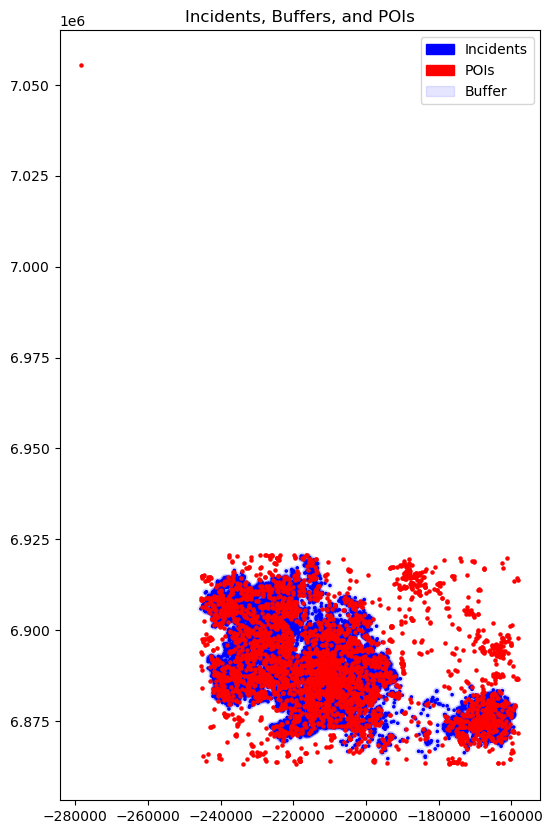

In [15]:
# Plot the incident locations with buffers and POIs
fig, ax = plt.subplots(figsize=(10, 10))

incidents_gdf.plot(ax=ax, color='blue', markersize=5, label='Incidents')
incidents_gdf.buffer(buffer_distance).plot(ax=ax, color='blue', alpha=0.1, label='Buffer')
poi_data.plot(ax=ax, color='red', markersize=5, label='POIs')

# Create custom legend handles
incidents_patch = mpatches.Patch(color='blue', label='Incidents')
pois_patch = mpatches.Patch(color='red', label='POIs')
buffer_patch = mpatches.Patch(color='blue', alpha=0.1, label='Buffer')

plt.legend(handles=[incidents_patch, pois_patch, buffer_patch])
plt.title('Incidents, Buffers, and POIs')
plt.show()

In [16]:
# Process data in batches
batch_size = 1000  # Adjust batch size as needed
incidents_df['poi_count'] = 0  # Initialize POI count column

for start in range(0, len(incidents_df), batch_size):
    end = min(start + batch_size, len(incidents_df))
    batch_incidents = incidents_df.iloc[start:end]
    batch_gdf = gpd.GeoDataFrame(batch_incidents, geometry=gpd.points_from_xy(batch_incidents.EASTINGS, batch_incidents.NORTHINGS), crs="EPSG:27700")
    batch_gdf = batch_gdf.to_crs(epsg=4326)
    batch_gdf = batch_gdf.to_crs(epsg=3857)
    batch_gdf['buffer'] = batch_gdf.geometry.buffer(buffer_distance)
    batch_gdf = batch_gdf.set_geometry('buffer')

    # Perform spatial join to find POIs within the buffer
    joined_gdf = gpd.sjoin(poi_data, batch_gdf[['buffer']], how="inner", predicate="within")

    # Count POIs within the buffer for each incident
    poi_counts = joined_gdf.groupby('index_right').size()
    incidents_df.loc[batch_incidents.index, 'poi_count'] = batch_incidents.index.map(poi_counts).fillna(0)

# Display the updated incidents DataFrame
print(incidents_df.head())

                 call_time incident_classification_level1       EASTINGS  \
355773 2023-01-01 00:07:31                           FIRE  390939.345292   
355774 2023-01-01 00:10:35                           FIRE  434909.864296   
355775 2023-01-01 00:15:51                           FIRE  406439.483461   
355776 2023-01-01 00:22:20                           FIRE  435218.924925   
355777 2023-01-01 00:24:54                           FIRE  393699.370009   

            NORTHINGS peak_hour day_type  season  \
355773  288314.930061  Off-Peak  Weekend  Winter   
355774  281352.454718  Off-Peak  Weekend  Winter   
355775  292133.553656  Off-Peak  Weekend  Winter   
355776  279144.353190  Off-Peak  Weekend  Winter   
355777  298870.429296  Off-Peak  Weekend  Winter   

        incident_classification_level1_encoded  poi_count  
355773                                       1          1  
355774                                       1          5  
355775                                       1    

In [17]:
print(incidents_gdf.crs)
print(poi_data.crs)

EPSG:3857
EPSG:3857


In [18]:
# Convert incident data to GeoDataFrame with original CRS (EPSG:27700)
incidents_gdf = gpd.GeoDataFrame(incidents_df, geometry=gpd.points_from_xy(incidents_df.EASTINGS, incidents_df.NORTHINGS), crs="EPSG:27700")

# Load Corine Land Cover data
corine_gdf = gpd.read_file('Corine_land_cover_2018_UK/data/clc2018_uk.shp')

# Ensure the CRS matches
corine_gdf = corine_gdf.to_crs(incidents_gdf.crs)

# Clip Corine data to the bounding box of the incident data
bounding_box = incidents_gdf.total_bounds
corine_gdf = corine_gdf.cx[bounding_box[0]:bounding_box[2], bounding_box[1]:bounding_box[3]]

# Define the mapping from Level 3 CLC_CODE to Level 2 LABEL2
level_2_mapping = {
    '111': 'Urban fabric', 
    '112': 'Urban fabric', 
    '121': 'Industrial, commercial and transport units', 
    '122': 'Industrial, commercial and transport units', 
    '123': 'Industrial, commercial and transport units', 
    '124': 'Industrial, commercial and transport units',
    '131': 'Mine, dump and construction sites', 
    '132': 'Mine, dump and construction sites', 
    '133': 'Mine, dump and construction sites', 
    '141': 'Artificial, non-agricultural vegetated areas', 
    '142': 'Artificial, non-agricultural vegetated areas',
    '211': 'Arable land', 
    '212': 'Arable land', 
    '213': 'Arable land',
    '221': 'Permanent crops', 
    '222': 'Permanent crops', 
    '223': 'Permanent crops',
    '231': 'Pastures',
    '241': 'Heterogeneous agricultural areas',
    '242': 'Heterogeneous agricultural areas', 
    '243': 'Heterogeneous agricultural areas', 
    '244': 'Heterogeneous agricultural areas',
    '311': 'Forests', 
    '312': 'Forests', 
    '313': 'Forests', 
    '321': 'Scrub and/or herbaceous vegetation associations', 
    '322': 'Scrub and/or herbaceous vegetation associations',
    '323': 'Scrub and/or herbaceous vegetation associations', 
    '324': 'Scrub and/or herbaceous vegetation associations',
    '331': 'Open spaces with little or no vegetation',
    '332': 'Open spaces with little or no vegetation', 
    '333': 'Open spaces with little or no vegetation', 
    '334': 'Open spaces with little or no vegetation', 
    '335': 'Open spaces with little or no vegetation',
    '411': 'Inland wetlands',
    '412': 'Inland wetlands', 
    '421': 'Maritime wetlands', 
    '422': 'Maritime wetlands', 
    '423': 'Maritime wetlands',
    '511': 'Inland waters', 
    '512': 'Inland waters', 
    '521': 'Marine waters', 
    '522': 'Marine waters', 
    '523': 'Marine waters'
    # Exclude 999, 990, and 995 as they are NODATA or UNCLASSIFIED
}

# Map Level 3 codes to Level 2 codes using 'CODE_18'
corine_gdf['level_2_code'] = corine_gdf['CODE_18'].map(level_2_mapping)

# Display the first few rows to verify the new Level 2 codes
print(corine_gdf.head())

# Buffer incidents to find nearby land cover types (e.g., within 500 meters)
buffer_distance = 500  # 500 meters
incidents_gdf['buffer'] = incidents_gdf.geometry.buffer(buffer_distance)

# Reset geometry to the buffer for spatial join
incidents_gdf_buffer = incidents_gdf.set_geometry('buffer')

# Spatial join to find land cover within the buffer
joined_gdf = gpd.sjoin(corine_gdf, incidents_gdf_buffer, how="inner", predicate="intersects")

# Calculate land cover proportions within each buffer
land_cover_counts = joined_gdf.groupby('index_right')['level_2_code'].value_counts(normalize=True).unstack(fill_value=0)

# Add land cover proportions as features to the incident data
incidents_df = incidents_df.join(land_cover_counts, on=incidents_df.index)

# Display the updated incidents DataFrame
print(incidents_df.head())


      OBJECTID_1  OBJECTID  Shape_Leng      ID CODE_18     Area_Ha Remark  \
3620        3621         0         0.0  UK_135     111  226.125932   None   
3622        3623         0         0.0  UK_137     111  471.321092   None   
3623        3624         0         0.0  UK_138     111  128.545225   None   
3625        3626         0         0.0  UK_140     111  115.797593   None   
3626        3627         0         0.0  UK_141     111   54.473417   None   

        Shape_Le_1    Shape_Le_2    Shape_Area  \
3620  10387.836505  10387.836505  2.261259e+06   
3622  12295.151220  12295.151220  4.713211e+06   
3623   7861.507367   7861.507367  1.285452e+06   
3625   6057.836338   6057.836338  1.157976e+06   
3626   3441.147980   3441.147980  5.447342e+05   

                                               geometry  level_2_code  
3620  POLYGON ((433490.840 278145.741, 433470.615 27...  Urban fabric  
3622  POLYGON ((406513.919 287987.116, 406508.998 28...  Urban fabric  
3623  POLYGON ((3945

In [19]:
# Load the IMD shapefile
imd_gdf = gpd.read_file('English_IMD_2019/IMD_2019.shp')

# Display the first few rows to understand the structure
print(imd_gdf.head())

    lsoa11cd                   lsoa11nm                  lsoa11nmw  \
0  E01000001        City of London 001A        City of London 001A   
1  E01000002        City of London 001B        City of London 001B   
2  E01000003        City of London 001C        City of London 001C   
3  E01000005        City of London 001E        City of London 001E   
4  E01000006  Barking and Dagenham 016A  Barking and Dagenham 016A   

      st_areasha   st_lengths  IMD_Rank  IMD_Decile  \
0  133320.768872  2291.846072     29199           9   
1  226191.272990  2433.960112     30379          10   
2   57302.966538  1142.359799     14915           5   
3  190738.760504  2167.868343      8678           3   
4  144195.846857  1935.510354     14486           5   

                    LSOA01NM      LADcd                 LADnm  ...  IndDec  \
0        City of London 001A  E09000001        City of London  ...       5   
1        City of London 001B  E09000001        City of London  ...       7   
2        City 

In [20]:
# Check CRS of IMD data
print(imd_gdf.crs)

# Transform the IMD data to match the CRS of incidents_gdf
if imd_gdf.crs != incidents_gdf.crs:
    imd_gdf = imd_gdf.to_crs(incidents_gdf.crs)

# Check the CRS again to ensure they match
print(incidents_gdf.crs)
print(imd_gdf.crs)

EPSG:27700
EPSG:27700
EPSG:27700


In [21]:
# Perform a spatial join
incidents_with_imd = gpd.sjoin(incidents_gdf, imd_gdf[['geometry', 'OutScore']], how="left", op='intersects')

# Rename 'OutScore' to 'IMD_score'
incidents_with_imd.rename(columns={'OutScore': 'IMD_score'}, inplace=True)

# Display the first few rows to check the results
print(incidents_with_imd.head())

# Fill any missing IMD scores with a default value
incidents_with_imd['IMD_score'].fillna(incidents_with_imd['IMD_score'].mean(), inplace=True)

# Ensure IMD_score column is in incidents_df
incidents_df['IMD_score'] = incidents_with_imd['IMD_score']

                 call_time incident_classification_level1       EASTINGS  \
355773 2023-01-01 00:07:31                           FIRE  390939.345292   
355774 2023-01-01 00:10:35                           FIRE  434909.864296   
355775 2023-01-01 00:15:51                           FIRE  406439.483461   
355776 2023-01-01 00:22:20                           FIRE  435218.924925   
355777 2023-01-01 00:24:54                           FIRE  393699.370009   

            NORTHINGS peak_hour day_type  season  \
355773  288314.930061  Off-Peak  Weekend  Winter   
355774  281352.454718  Off-Peak  Weekend  Winter   
355775  292133.553656  Off-Peak  Weekend  Winter   
355776  279144.353190  Off-Peak  Weekend  Winter   
355777  298870.429296  Off-Peak  Weekend  Winter   

        incident_classification_level1_encoded  poi_count  \
355773                                       1          1   
355774                                       1          5   
355775                                       1 

/opt/conda/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3466: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


## Exploratory Data Analysis (EDA)

In [22]:
# Check the dataframe info
print(incidents_df.info())

# Check for missing values
print(incidents_df.isnull().sum())

# Display basic statistics
print(incidents_df.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 19074 entries, 355773 to 383667
Data columns (total 20 columns):
 #   Column                                           Non-Null Count  Dtype         
---  ------                                           --------------  -----         
 0   call_time                                        19074 non-null  datetime64[ns]
 1   incident_classification_level1                   19074 non-null  object        
 2   EASTINGS                                         19074 non-null  float64       
 3   NORTHINGS                                        19074 non-null  float64       
 4   peak_hour                                        19074 non-null  object        
 5   day_type                                         19074 non-null  object        
 6   season                                           19074 non-null  object        
 7   incident_classification_level1_encoded           19074 non-null  int64         
 8   poi_count                          

/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


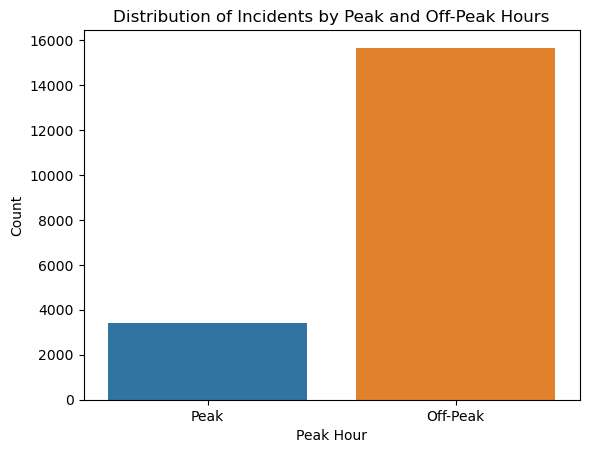

/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


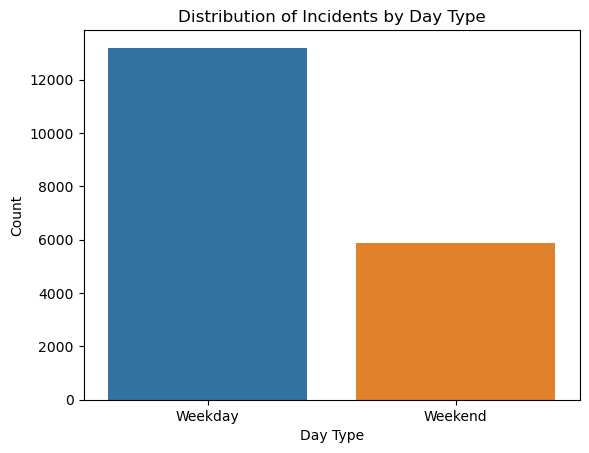

/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


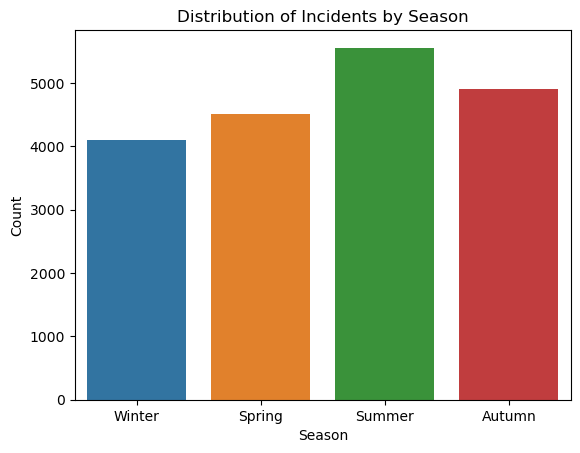

/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


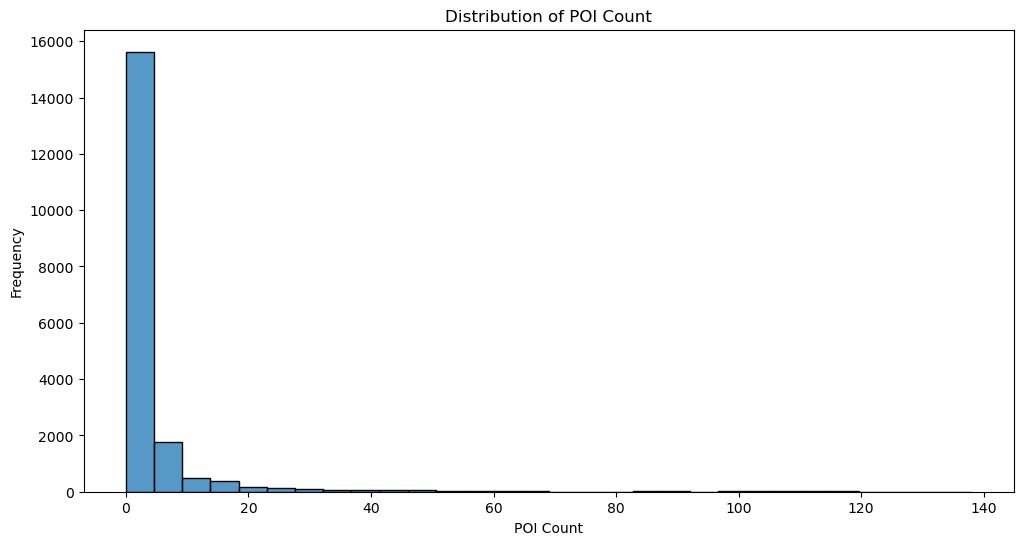

/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


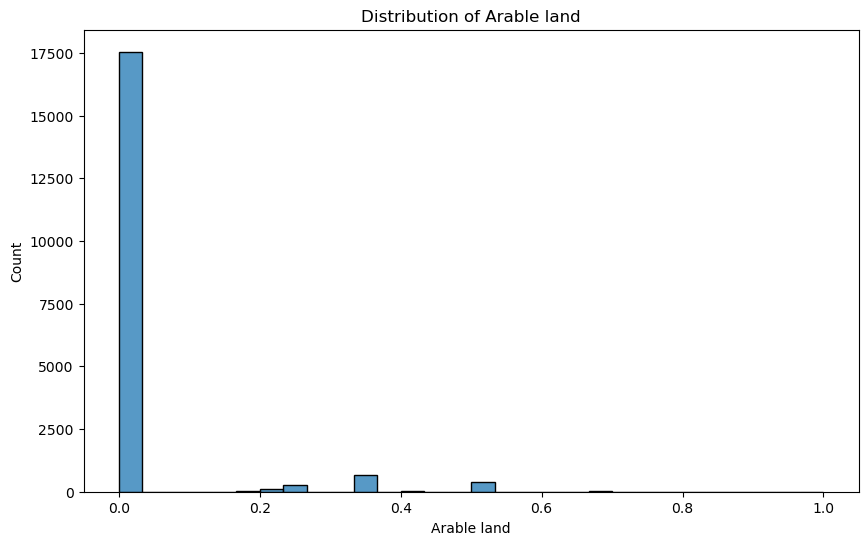

/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


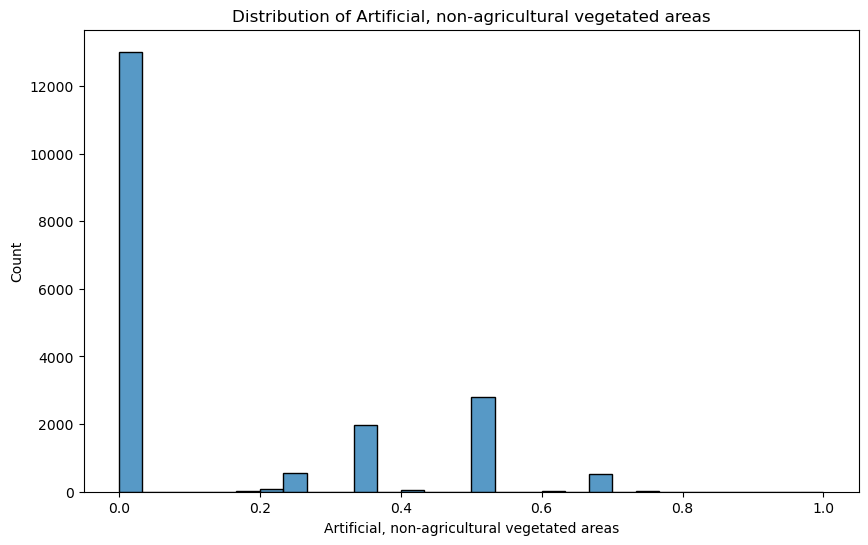

/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


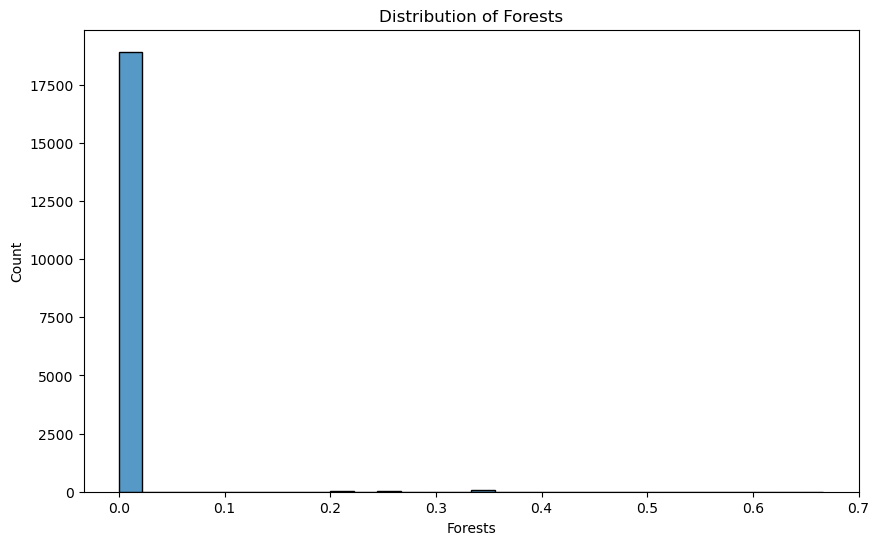

/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


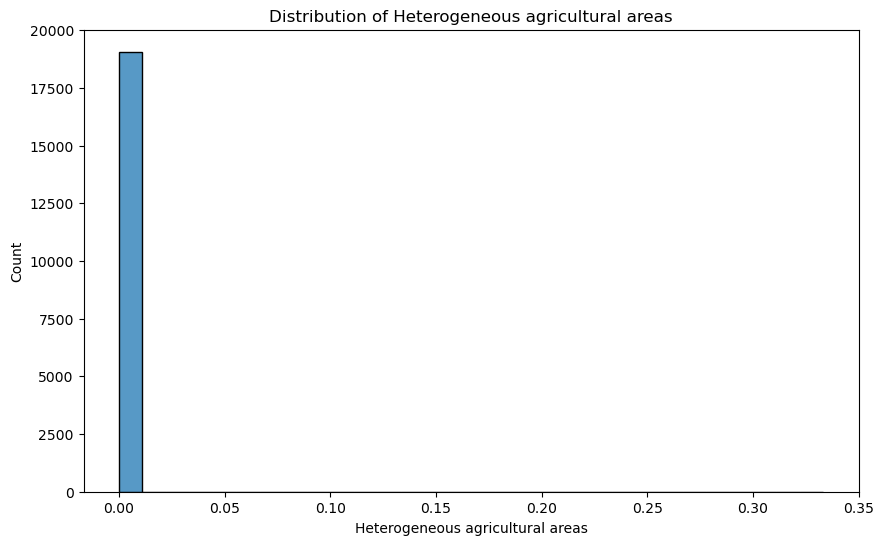

/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


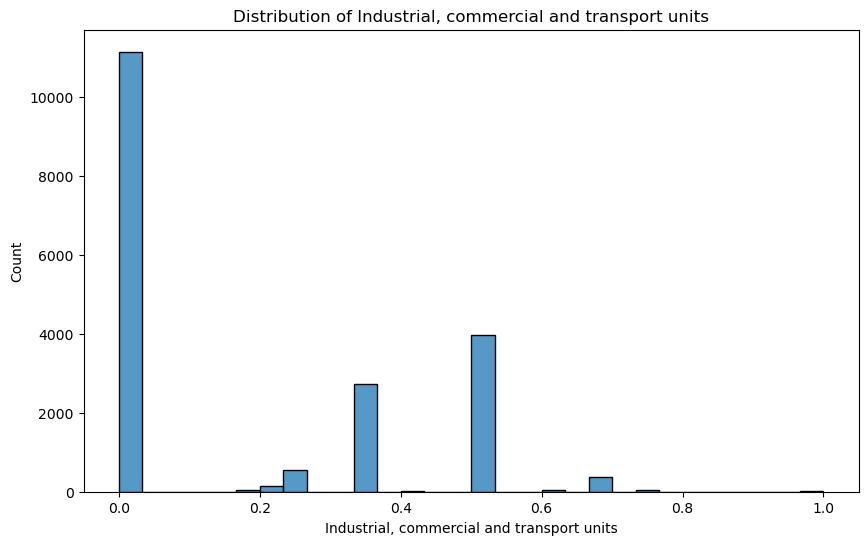

/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


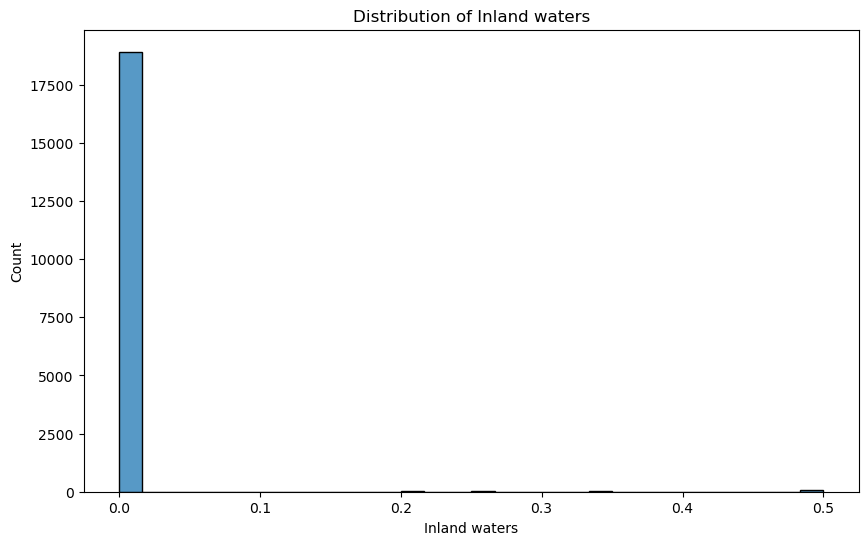

/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


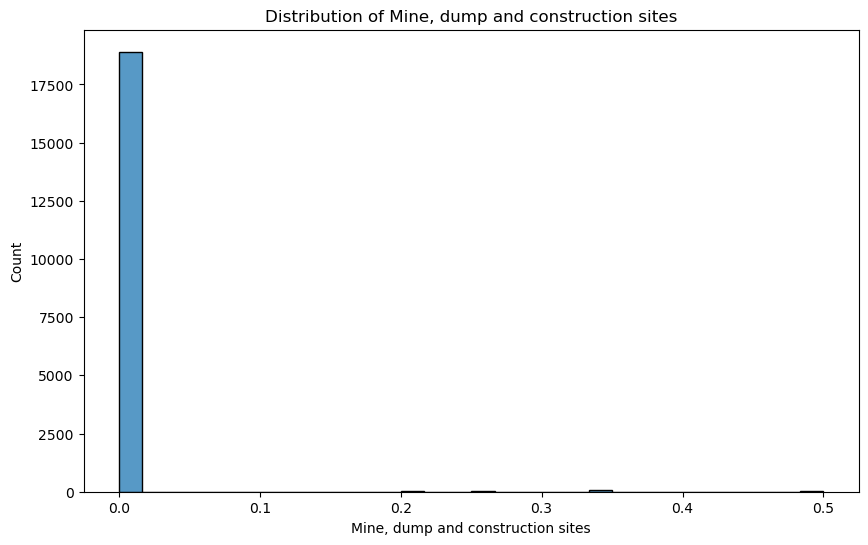

/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


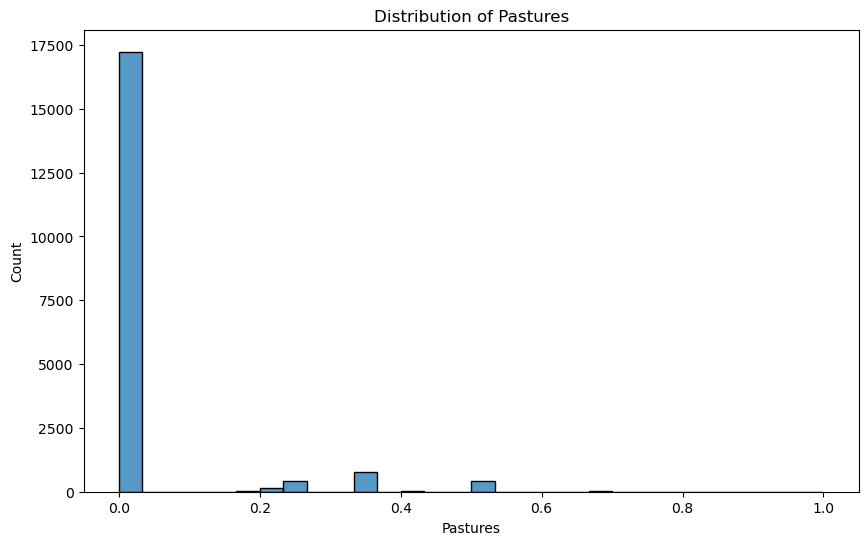

/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


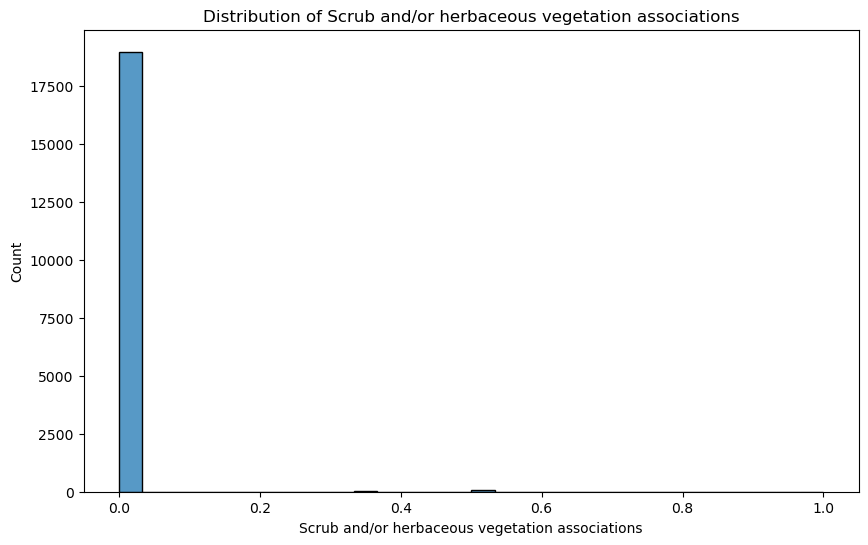

/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


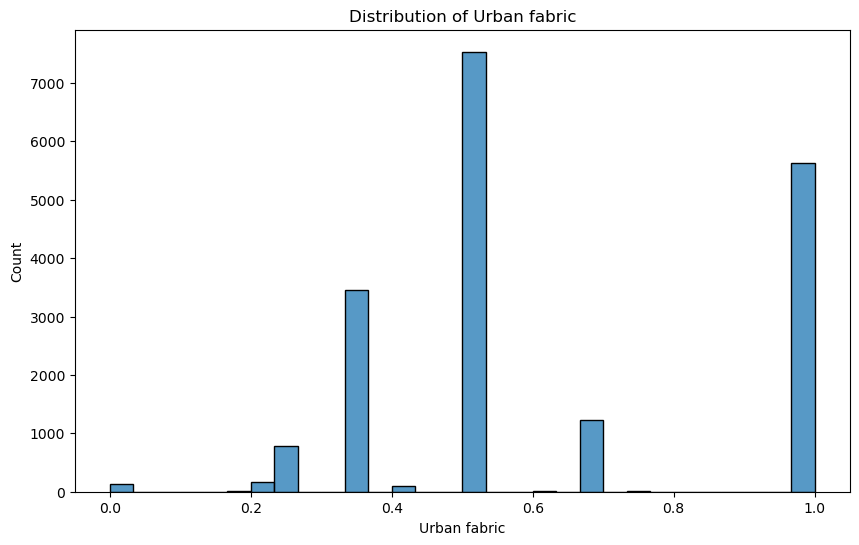

/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


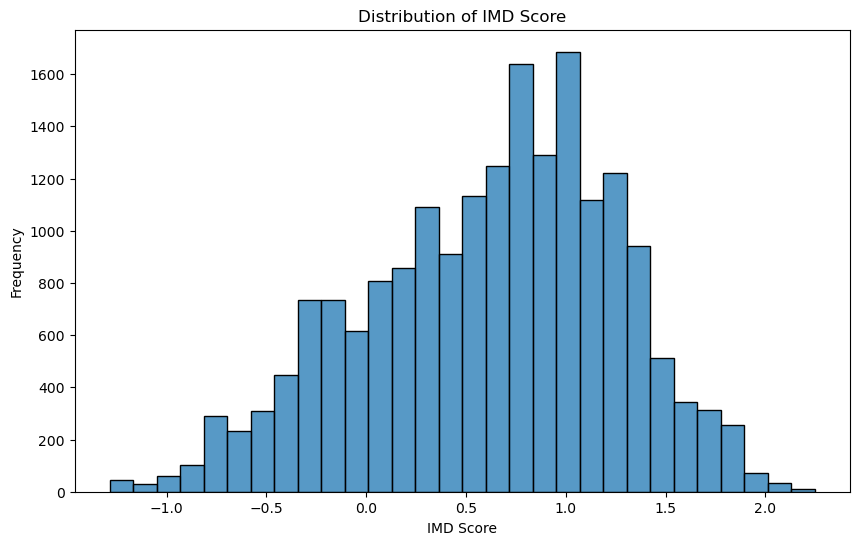

/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dty

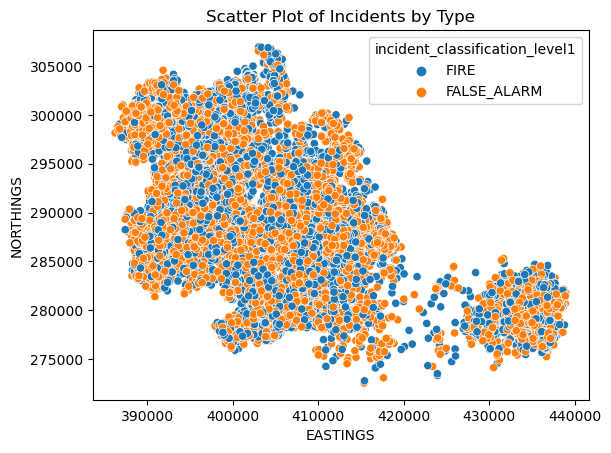

In [23]:
# Distribution of incidents by peak and off-peak hours
sns.countplot(data=incidents_df, x='peak_hour', order=['Peak', 'Off-Peak'])
plt.title('Distribution of Incidents by Peak and Off-Peak Hours')
plt.xlabel('Peak Hour')
plt.ylabel('Count')
plt.show()

# Distribution of incidents by day type (Weekday/Weekend)
sns.countplot(data=incidents_df, x='day_type', order=['Weekday', 'Weekend'])
plt.title('Distribution of Incidents by Day Type')
plt.xlabel('Day Type')
plt.ylabel('Count')
plt.show()

# Distribution of incidents by season
sns.countplot(data=incidents_df, x='season', order=['Winter', 'Spring', 'Summer', 'Autumn'])
plt.title('Distribution of Incidents by Season')
plt.xlabel('Season')
plt.ylabel('Count')
plt.show()

# Distribution of poi_count
plt.figure(figsize=(12, 6))
sns.histplot(incidents_df['poi_count'], bins=30, kde=False)
plt.title('Distribution of POI Count')
plt.xlabel('POI Count')
plt.ylabel('Frequency')
plt.show()

# Loop through each land cover feature and create a histogram for each
land_cover_features = list(land_cover_counts.columns)
for feature in land_cover_features:
    plt.figure(figsize=(10, 6))
    sns.histplot(incidents_df[feature], bins=30, kde=False)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.show()

# Distribution of out_score
plt.figure(figsize=(10, 6))
sns.histplot(incidents_with_imd['IMD_score'], bins=30, kde=False)
plt.title('Distribution of IMD Score')
plt.xlabel('IMD Score')
plt.ylabel('Frequency')
plt.show()

# Scatter plot of incidents
sns.scatterplot(x='EASTINGS', y='NORTHINGS', hue='incident_classification_level1', data=incidents_df)
plt.title('Scatter Plot of Incidents by Type')
plt.show()

In [24]:
# Define features and target variable
features = ['peak_hour', 'day_type', 'season', 'poi_count', 'IMD_score'] + land_cover_features

# One-hot encode the categorical features
X = pd.get_dummies(incidents_df[features], drop_first=True)

# Convert all features to float type
X = X.astype(np.float32)

# Target variable
y = incidents_df['incident_classification_level1_encoded']

# Display the first few rows of the features and target
print(X.head())
print(y.head())


        poi_count  IMD_score  Arable land  \
355773        1.0     -0.541          0.0   
355774        5.0      1.040          0.0   
355775        2.0      0.766          0.0   
355776        6.0      0.507          0.0   
355777        0.0      0.283          0.0   

        Artificial, non-agricultural vegetated areas  Forests  \
355773                                      0.666667      0.0   
355774                                      0.000000      0.0   
355775                                      0.500000      0.0   
355776                                      0.000000      0.0   
355777                                      0.250000      0.0   

        Heterogeneous agricultural areas  \
355773                               0.0   
355774                               0.0   
355775                               0.0   
355776                               0.0   
355777                               0.0   

        Industrial, commercial and transport units  Inland waters  \
3557

incident_classification_level1_encoded
0    10568
1     8506
Name: count, dtype: int64


/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


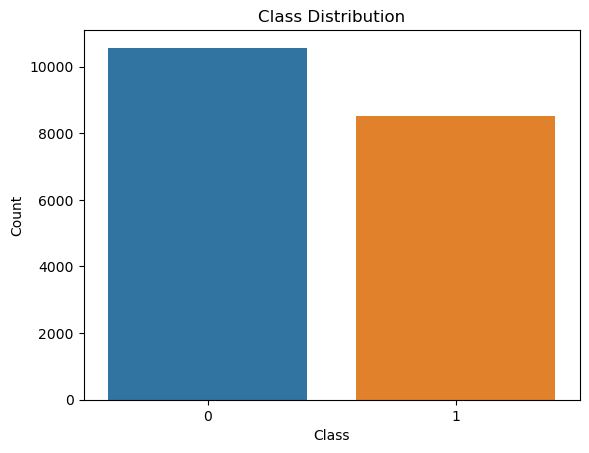

In [25]:
class_counts = y.value_counts()
print(class_counts)

# Plot the distribution
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

In [26]:
proportion = 8506 / (10568 + 8506)
print(proportion)

0.4459473629023802


## Model Training and Evaluation

In [27]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [28]:
# Create a function to evaluate the models using the specified metrics
def evaluate_model(y_test, y_pred, y_prob):
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    print("AUC-ROC:", roc_auc_score(y_test, y_prob))

In [29]:
# Train a Logistic Regression model
log_reg_model = LogisticRegression(random_state=42)
log_reg_model.fit(X_train, y_train)

# Predict and evaluate
log_reg_predictions = log_reg_model.predict(X_test)
log_reg_probabilities = log_reg_model.predict_proba(X_test)[:, 1]
evaluate_model(y_test, log_reg_predictions, log_reg_probabilities)

Confusion Matrix:
[[2692  458]
 [1989  584]]

Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.85      0.69      3150
           1       0.56      0.23      0.32      2573

    accuracy                           0.57      5723
   macro avg       0.57      0.54      0.51      5723
weighted avg       0.57      0.57      0.52      5723

Precision: 0.5604606525911708
Recall: 0.22697240575204042
F1 Score: 0.32309820193637623
AUC-ROC: 0.5912932837340144


In [30]:
# Train a Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict and evaluate
rf_predictions = rf_model.predict(X_test)
rf_probabilities = rf_model.predict_proba(X_test)[:, 1]
evaluate_model(y_test, rf_predictions, rf_probabilities)

Confusion Matrix:
[[2054 1096]
 [1335 1238]]

Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.65      0.63      3150
           1       0.53      0.48      0.50      2573

    accuracy                           0.58      5723
   macro avg       0.57      0.57      0.57      5723
weighted avg       0.57      0.58      0.57      5723

Precision: 0.5304198800342759
Recall: 0.4811504080839487
F1 Score: 0.5045852863256572
AUC-ROC: 0.5975700035163696


In [31]:
# Train an XGBoost model
xgb_model = xgb.XGBClassifier(objective='binary:logistic', n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

# Predict and evaluate
xgb_predictions = xgb_model.predict(X_test)
xgb_probabilities = xgb_model.predict_proba(X_test)[:, 1]
evaluate_model(y_test, xgb_predictions, xgb_probabilities)

Confusion Matrix:
[[2201  949]
 [1342 1231]]

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.70      0.66      3150
           1       0.56      0.48      0.52      2573

    accuracy                           0.60      5723
   macro avg       0.59      0.59      0.59      5723
weighted avg       0.60      0.60      0.59      5723

Precision: 0.5646788990825689
Recall: 0.4784298484259619
F1 Score: 0.517988638754471
AUC-ROC: 0.6364511810683595


In [32]:
# Define the Neural Network model
nn_model = Sequential()

# Input layer and first hidden layer with 32 neurons, ReLU activation
nn_model.add(Dense(32, input_dim=X_train.shape[1], activation='relu'))

# Dropout layer to prevent overfitting
nn_model.add(Dropout(0.5))

# Second hidden layer with 16 neurons, ReLU activation
nn_model.add(Dense(16, activation='relu'))

# Dropout layer to prevent overfitting
nn_model.add(Dropout(0.5))

# Output layer with 1 neuron and sigmoid activation for binary classification
nn_model.add(Dense(1, activation='sigmoid'))

# Compile the model with binary crossentropy loss and Adam optimizer
nn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model with 50 epochs and a batch size of 32
nn_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Predict and evaluate
nn_probabilities = nn_model.predict(X_test).ravel()
nn_predictions = (nn_probabilities > 0.5).astype(int)

# Evaluate the neural network model
evaluate_model(y_test, nn_predictions, nn_probabilities)

Epoch 1/50


/opt/conda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


418/418 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5143 - loss: 0.7397 - val_accuracy: 0.5483 - val_loss: 0.6861
Epoch 2/50
418/418 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5402 - loss: 0.6939 - val_accuracy: 0.5511 - val_loss: 0.6854
Epoch 3/50
418/418 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5528 - loss: 0.6889 - val_accuracy: 0.5513 - val_loss: 0.6852
Epoch 4/50
418/418 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5560 - loss: 0.6845 - val_accuracy: 0.5511 - val_loss: 0.6847
Epoch 5/50
418/418 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5557 - loss: 0.6863 - val_accuracy: 0.5511 - val_loss: 0.6836
Epoch 6/50
418/418 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5507 - loss: 0.6862 - val_accuracy: 0.5508 - val_loss: 0.6826
Epoch 7/50
418/418 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5559 - loss: 0.6819 - val_accuracy: 0.5520 - val_loss: 0.6829
Epoch 8/50
418/418 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5607 - loss: 0.6842 - val_accuracy: 0.5534 - val_